## 뉴럴 스타일 변환

신경망을 이용한 스타일 전이(neural style transfer)는 2015년 Leon Gatys에 의해 소개된 이미지 수정 방법으로 참조 이미지(reference image)와 목표 이미지(target)가 있을 때 목표 이미지의 내용(content)은 보존하면서 참조 이미지의 스타일(style)을 목표 이미지에 적용하는 것이다. 여기에서 스타일은 그림의 색상이나 패턴과 같은 세부적 특성을 말한다.

<img src="https://datascienceschool.net/upfiles/a372a4ab0da74219bb3a7a6a250e2154.png">

신경 스타일 전이의 목표는 목표 이미지에서는 내용을, 참조 이미지에서는 스타일을 보존하는 것이다. 따라서 최소화하고자하는 손실함수는 다음과 같다.

```
손실함수 = distance(style(참조 이미지) - style(생성된 이미지)) 
       + distance(content(목표 이미지) - content(생성된 이미지))
```

이 식에서 `style()` 함수는 이미지로부터 스타일 정보 벡터를 추출하는 함수고 `content()` 함수는 내용 정보 벡터를 추출하는 함수다. `distance()` 함수는 두 정보 벡터간의 거리를 측정하는 함수로 벡터 놈(norma)을 사용한다. 

신경 스타일 전이는 CNN의 초기 레이어의 출력값이 이미지의 국지적인 정보 즉, 스타일 정보를 나타내고 끝부분 레이어의 출력값은 이미지의 전반적이고 추상적인 정보 즉, 내용 정보를 나타낸다는 점을 이용한다. 

따라서 `content()` 함수는 입력 이미지를 CNN에 넣었을 때 마지막 부분의 레이어 출력값을 사용한다. 

스타일의 경우에는 하나의 초기 레이어에서만 출력되는 것이 아니라 여러 개의 초기 레이어들에서 출력되므로 이 경우에는 복수 레이어의 출력 벡터를 서로 내적하여 만든 그램 행렬(Gram matrix)를 스타일 정보로 사용한다. 이 행렬은 여러 레이어의 내적으로 만들어 진 것이기 때문에, 각 레이어 간의 상관관계 정보를 가지고 있다. 이 상관관계 정보가 이미지가 가지고 있는 복합적인 스타일을 표현한다. 결과적으로 신경 스타일 전이 각 초기 레이어 출력간의 상관관계를 최대한 보존하며 이미지가 변환한다.

In [1]:
import tensorflow as tf

tf.__version__

'2.0.0'

### 예제 이미지 다운로드

다음과 같은 두 개의 이미지를 목표 이미지와 참조 이미지로 하여 스타일 전이를 구현해보자.

* 목표 이미지: 풍경 사진
* 참조 이미지: 빈센트 반 고흐의 별이 빛나는 밤

In [2]:
from sklearn.datasets import load_sample_image

content_image = tf.constant(load_sample_image('china.jpg'))
style_path = tf.keras.utils.get_file(
    'starrynight.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/757px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
)
style_image = tf.image.decode_image(tf.io.read_file(style_path), channels=3)

def preprocess_img(img):
    "이미지 가로 길이를 512로 통일"

    # 0~255 uint 자료형을 0 ~ 1 실수 자로형으로 변환한다.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    # 이미지의 가로, 세로 중 긴 변의 값(가로 길이)
    long_dim = max(shape)
    # 이미지의 목표 가로 길이
    max_dim = 512
    # 목표 크기와의 비율
    scale = max_dim / long_dim
    # 새 크기
    new_shape = tf.cast(shape * scale, tf.int32)
    # 이미지 크기 변화
    img = tf.image.resize(img, new_shape)
    # 1장짜리 배치 데이터(4차원 텐서)로 변환 
    img = img[tf.newaxis, :]
    
    return img


content_image = preprocess_img(content_image)
style_image = preprocess_img(style_image)

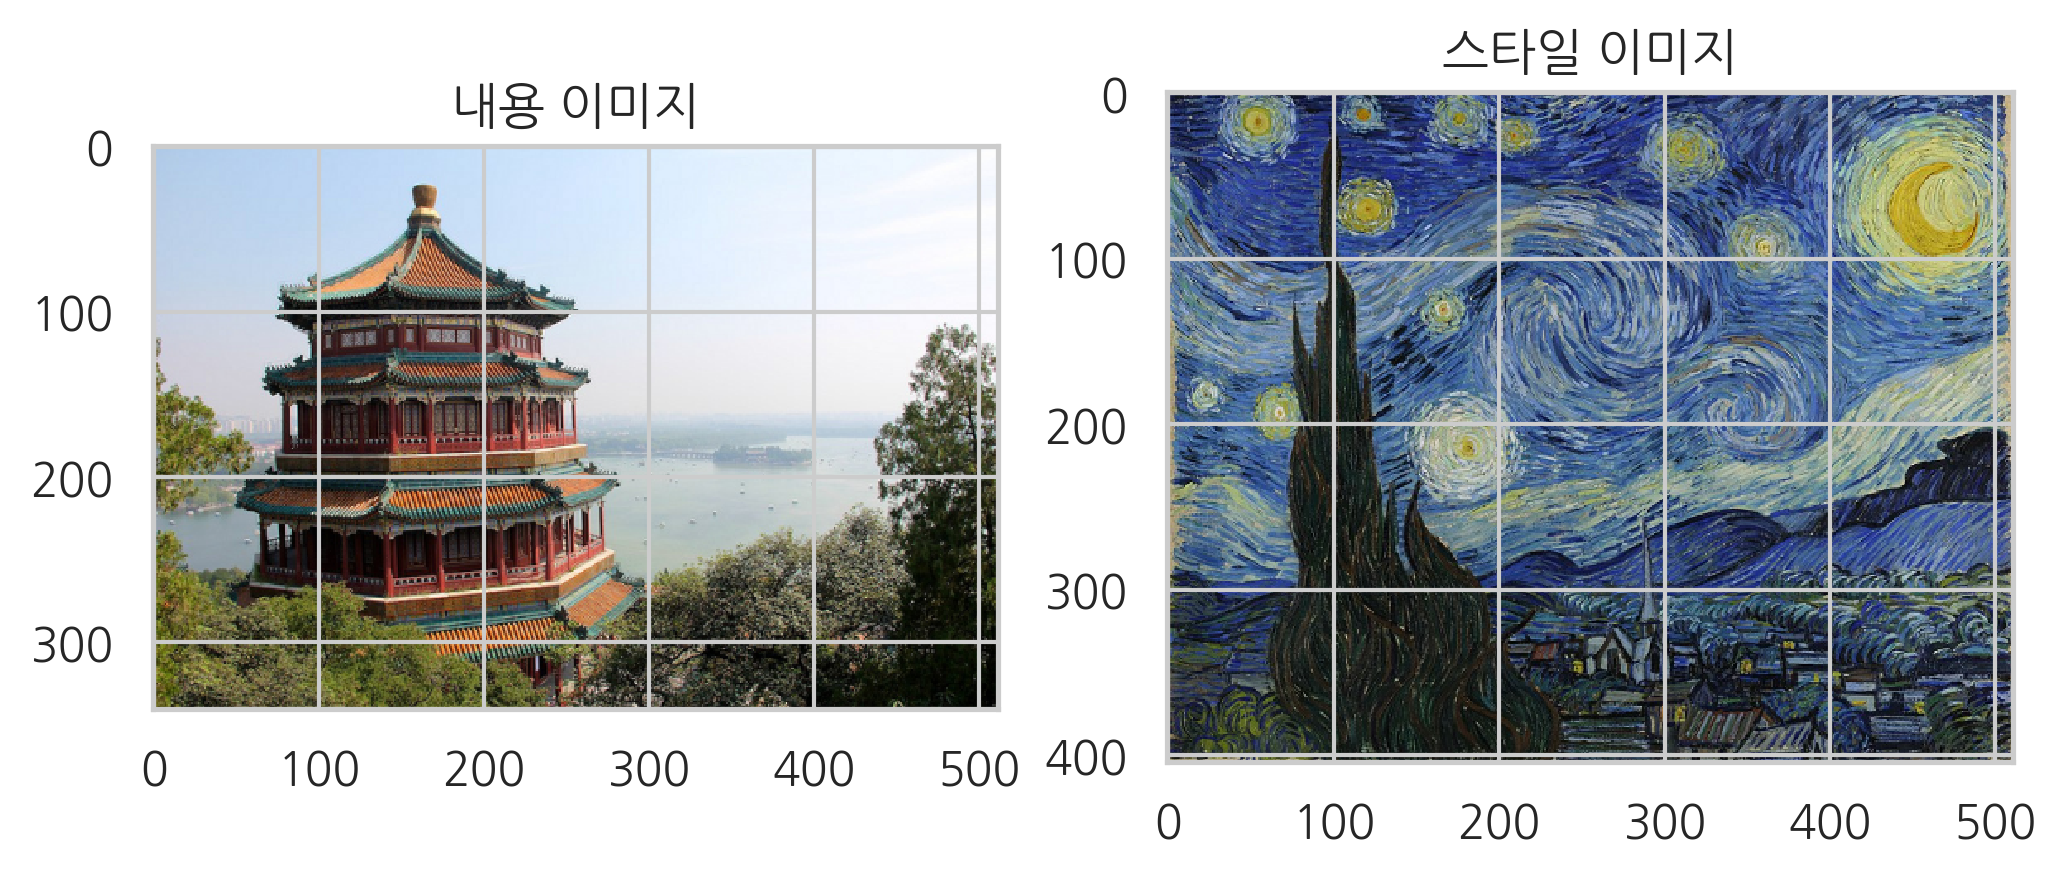

In [3]:
plt.subplot(121)
plt.imshow(tf.squeeze(content_image))
plt.title("내용 이미지")
plt.subplot(122)
plt.imshow(tf.squeeze(style_image))
plt.title("스타일 이미지")
plt.show()

### 스타일 전이 구현

In [4]:
# VGG19 모형

from tensorflow.keras.applications import VGG19

vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [5]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [6]:
from tensorflow.keras.applications.vgg19 import preprocess_input

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)


class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        "VGG 모형 입력으로부터 스타일 레이어와 내용 레이어를 출력하는 모형을 만든다."
        super(StyleContentModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.vgg = tf.keras.Model([vgg.input], outputs) 
        self.vgg.trainable = False

    def call(self, inputs):
        "입력"
        # 이미지의 0 ~ 1 입력을 0 ~ 255로 확대
        inputs = inputs * 255.0
        # 이미지넷 데이터의 평균으로 정규화
        preprocessed_input = preprocess_input(inputs)
        # 스타일 레이어와 컨텐트 레이어의 출력
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # 그램 행렬로 각 레이어의 스타일 출력값 계산
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        #컨텐트와 스타일 출력을 딕셔너리로 정리
        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [7]:

class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        "VGG 모형 입력으로부터 스타일 레이어와 컨텐트 레이어를 출력하는 모형을 만든다."
        super(StyleContentModel, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.num_style_layers = len(style_layers)
        outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
        self.vgg = tf.keras.Model([vgg.input], outputs) 
        self.vgg.trainable = False

    def call(self, inputs):
        "입력"
        # 이미지의 0 ~ 1 입력을 0 ~ 255로 확대
        inputs = inputs * 255.0
        # 이미지넷 데이터의 평균으로 정규화
        preprocessed_input = preprocess_input(inputs)
        # 스타일 레이어와 컨텐트 레이어의 출력
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        # 그램 행렬로 각 레이어의 스타일 출력값 계산
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]
        
        #컨텐트와 스타일 출력을 딕셔너리로 정리
        content_dict = {content_name: value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [8]:
extractor = StyleContentModel(style_layers, content_layers)

# 참조 이미지의 각 스타일 레이어 출력의 그램 행렬
style_targets = extractor(style_image)['style']

# 목표 이미지의 내용 레이어 출력
content_targets = extractor(content_image)['content']

In [9]:
style_weight = 1e-2
content_weight = 1e4

def style_content_loss(outputs):
    # outputs는 현재 이미지의 스타일 및 내용 출력
    # 현재 이미지의 스타일 출력(의 그램 행렬)
    style_outputs = outputs['style']
    # 현재 이미지의 내용 출력
    content_outputs = outputs['content']
    # 현재 이미지의 스타일 출력과 참조 이미지의 스타일 출력의 차이 계산
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2) 
                           for name in style_outputs.keys()])
    # 컨텐트 손실함수 값과 더하기 전에 가중치 부여
    style_loss *= style_weight / num_style_layers
    # 현재 이미지의 내용 출력과 목표 이미지의 내용 출력의 차이 계산
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2) 
                             for name in content_outputs.keys()])
    # 가중치 부여
    content_loss *= content_weight / num_content_layers
    # 최종 손실함수 계산
    loss = style_loss + content_loss
    return loss

In [10]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def train_step(image):
    with tf.GradientTape() as tape:
        # 현재 이미지에서 스타일 레이어 및 내용 레이어 출력을 계산
        outputs = extractor(image)
        # 현재 이미지의 손실함수값 계산
        loss = style_content_loss(outputs)

    # 그레디언트 벡터 계산
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    
    # 새로운 이미지 저장
    image_clipped = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    image.assign(image_clipped)

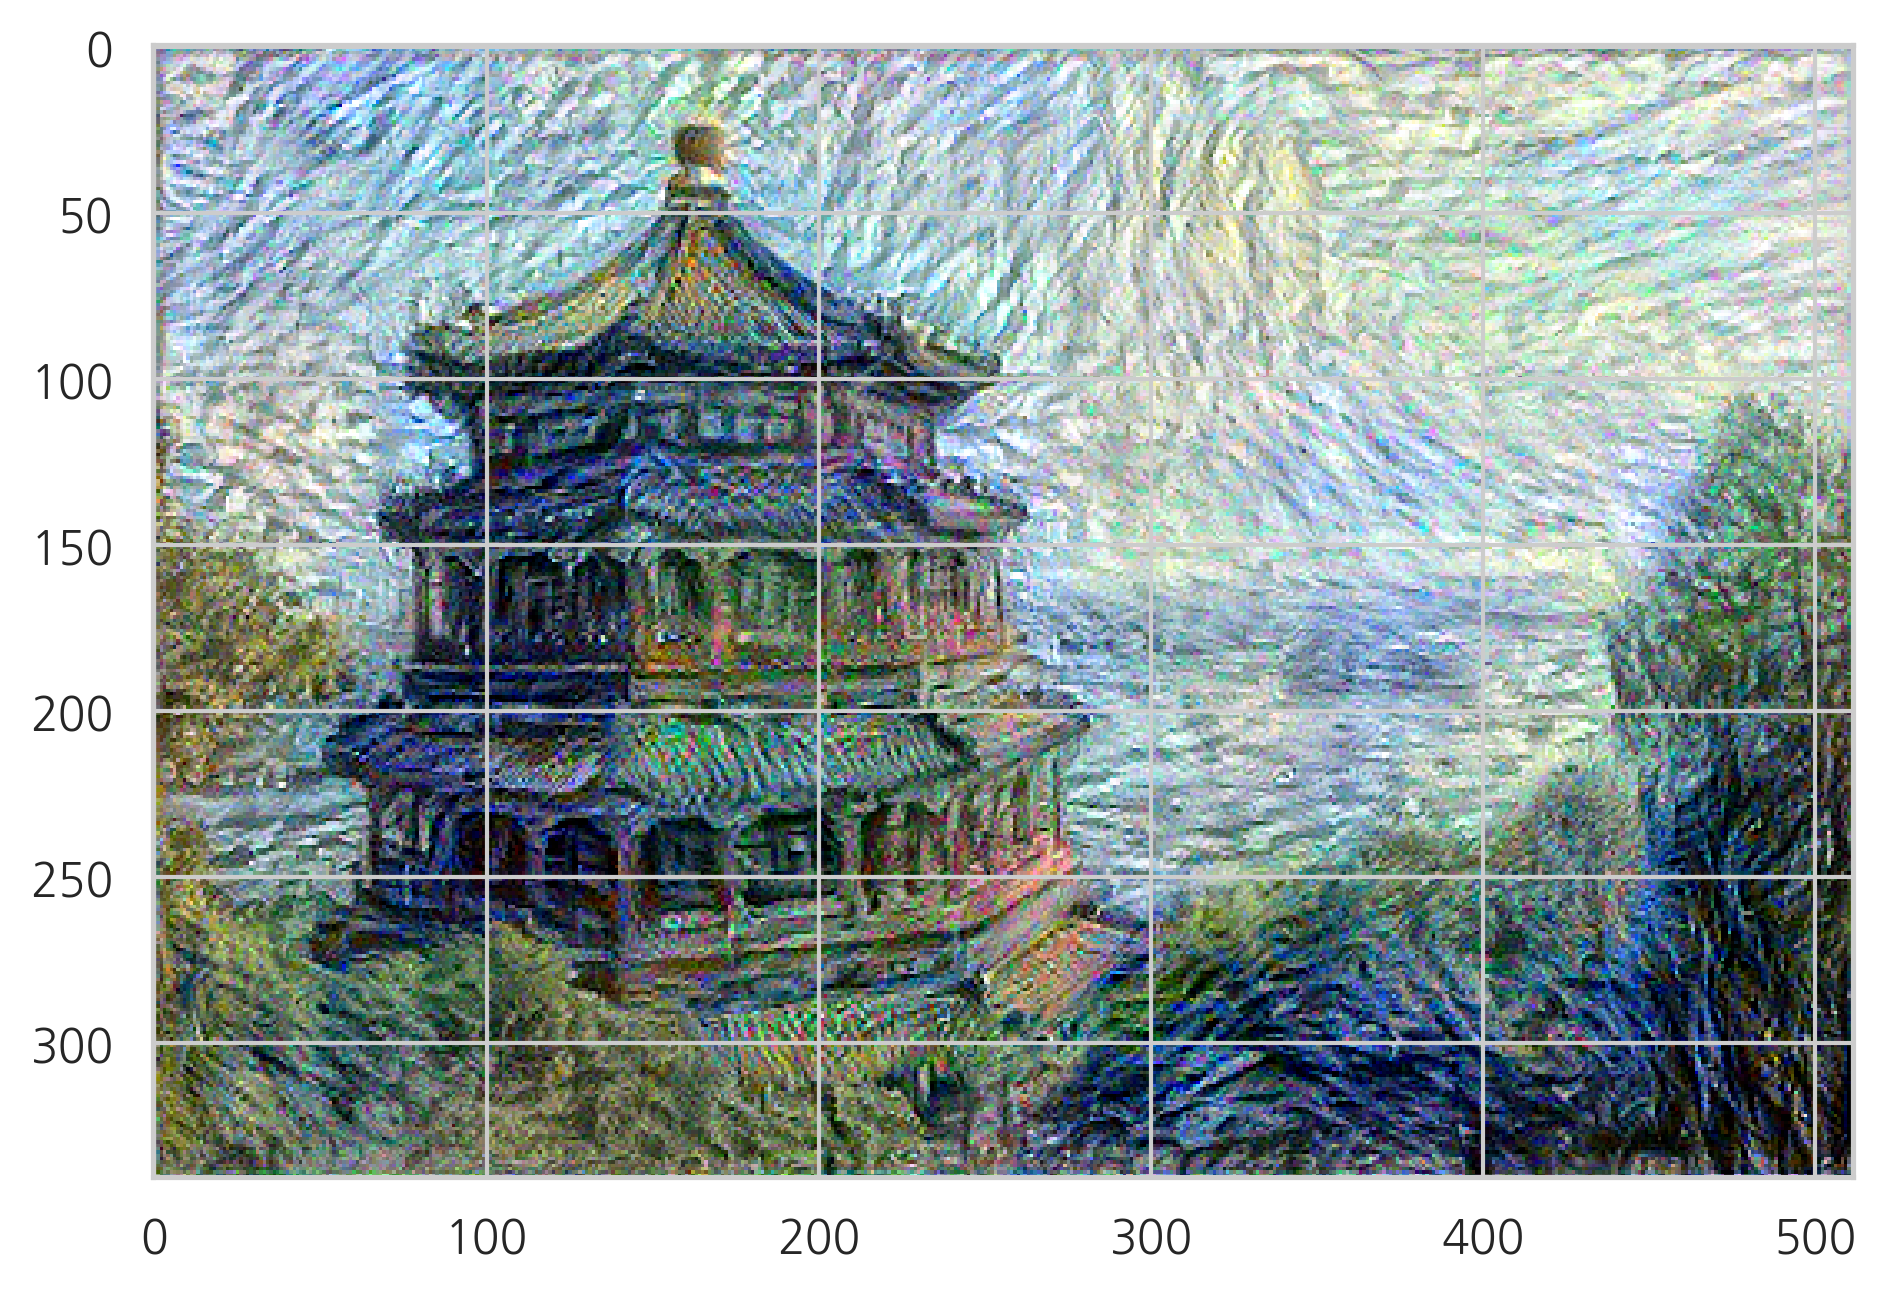

CPU times: user 23min 51s, sys: 3min 4s, total: 26min 56s
Wall time: 10min 17s


In [11]:
%%time

image = tf.Variable(content_image)
for n in range(200):
    train_step(image)
    
plt.imshow(tf.squeeze(image))
plt.show()